# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ovm.monetary.model import MonetaryModel

import logging
import os
import random
import typing as tp

import line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
from mesa.datacollection import DataCollector
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from ovm.monetary.agents import (
    MonetaryAgent, 
    MonetaryArbitrageur, 
    MonetaryKeeper
)

from ovm.monetary.markets import MonetaryFMarket
from ovm.monetary.model import MonetaryModel
from ovm.monetary.options import DataCollectionOptions
from ovm.monetary.plot_labels import (
    price_deviation_label,
    spot_price_label,
    futures_price_label,
    skew_label,
    inventory_wealth_ovl_label,
    inventory_wealth_usd_label,
    GINI_LABEL,
    GINI_ARBITRAGEURS_LABEL,
    SUPPLY_LABEL,
    TREASURY_LABEL,
    LIQUIDITY_LABEL, 
)

from ovm.monetary.reporters import * 
from ovm.monetary.data_io import (
    construct_ticker_to_series_of_prices_map, 
    construct_ticker_to_series_of_prices_map_from_simulated_prices
)

from ovm.paths import (
    HISTORICAL_DATA_DIRECTORY,
    SIMULATED_DATA_DIRECTORY
)

from ovm.simulation.bootstrap import plot_multivariate_simulation
from ovm.simulation.resampling import (
    load_log_returns,
    simulate_new_price_series_via_bootstrap,
    store_simulated_price_series_in_output_directory
)

from ovm.tickers import (
    ETH_USD_TICKER,
    COMP_USD_TICKER,
    LINK_USD_TICKER,
    YFI_USD_TICKER
)

from ovm.time_resolution import (
    TimeResolution, 
    TimeScale
)

DEFAULT_FIGURE_SIZE = (16, 9)

In [3]:
logger = logging.getLogger(__name__)
logger.level

0

In [4]:
logging.getLevelName(logging.root.level)

'WARNING'

In [5]:
logging.root.level

30

In [6]:
%load_ext line_profiler

# Set Parameters

In [7]:
time_resolution = TimeResolution.FIFTEEN_SECONDS

# 200000 steps corresponds to about 1.14 months
# 200000 * 15 / 60 / 60 / 24 / 365.25 * 12 = 1.14077116131
# number_of_steps_to_simulate = 200000

# number_of_steps_to_simulate = 1000

# 700000 steps corresponds to about 4 months (i.e. 1/3 year with 15 seconds per step)
# 700000 * 15 / 60 / 60 / 24 / 365.25 = 0.33272492204
# number_of_steps_to_simulate = 700000


# run agent based simulations for 2 years
number_of_steps_to_simulate = int(2 * 365.25 * 24 * 60 * 60 / time_resolution.in_seconds)
print(f'number_of_steps_to_simulate={number_of_steps_to_simulate}')

directory_path = os.path.join(HISTORICAL_DATA_DIRECTORY, str(time_resolution.value))
numpy_seed = 42

tickers = [ETH_USD_TICKER,
           # not a long history of simulation (can we use a different token instead)
           COMP_USD_TICKER,
           # not a long history of simulation (can we use a different token instead)
           LINK_USD_TICKER,
           # less than half a year of simulation (can we use a different token instead)
           YFI_USD_TICKER
           ]

ovl_usd_replacement_ticker = 'YFI-USD'
ovl_usd_ticker = 'OVL-USD'

tickers_with_ovl = [ovl_usd_ticker if ticker == ovl_usd_replacement_ticker else ticker for ticker in tickers]
tickers_with_ovl

number_of_steps_to_simulate=4207680


['ETH-USD', 'COMP-USD', 'LINK-USD', 'OVL-USD']

In [8]:
# skew_labels = [skew_label(ticker) for ticker in TICKERS]
# skew_labels

# Load Historical Price Data and Resample

In [9]:
log_return_df, closing_price_df, initial_prices = \
    load_log_returns(series_names=tickers,
                     period_length_in_seconds=time_resolution.in_seconds,
                     directory_path=directory_path)
log_return_df.shape

(705007, 4)

In [10]:
simulated_sample_length_in_seconds = \
    5 * 365.25 * 24 * 60 * 60

# simulated_sample_length_in_seconds = log_return_df.shape[0] * time_resolution.in_seconds
np.random.seed(numpy_seed)

simulated_prices = \
    simulate_new_price_series_via_bootstrap(
        initial_prices=initial_prices,
        input_log_return_df=log_return_df,
        time_resolution=time_resolution,
        block_length_in_seconds=4 * 24 * 60 * 60,  # 4 day block length
        simulated_sample_length_in_steps_in_seconds=simulated_sample_length_in_seconds,
            number_of_paths=1)
simulated_prices.shape

(1, 10519200, 4)

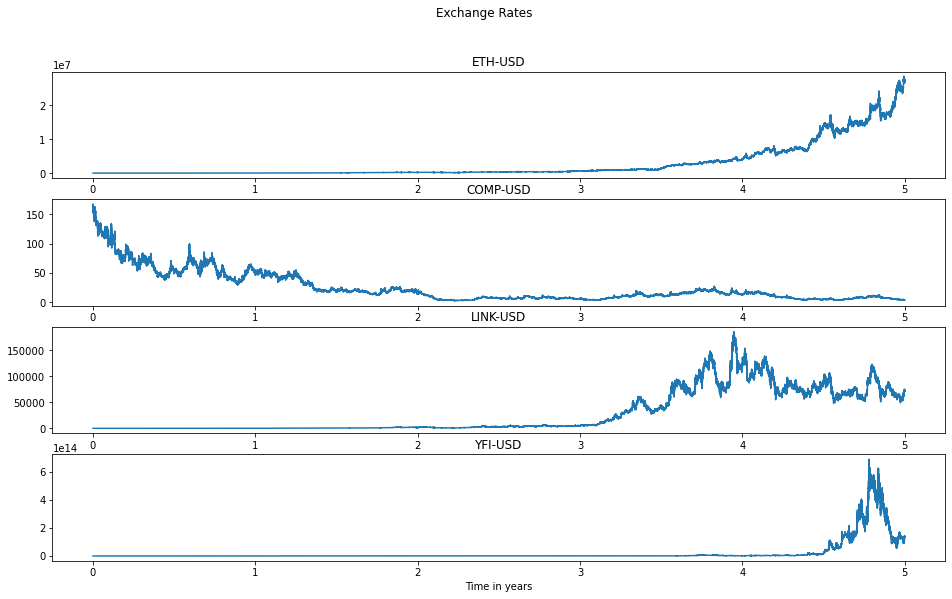

In [11]:
plot_multivariate_simulation(simulated_data=simulated_prices,
                             series_names=tickers, 
                             time_resolution=time_resolution, 
                             title='Exchange Rates')

In [12]:
ticker_to_time_series_of_prices_map = \
    construct_ticker_to_series_of_prices_map_from_simulated_prices(simulated_prices=simulated_prices, 
                                                                   tickers=tickers_with_ovl)

# Load Resampled Data

# Construct Agent Based Monetary Model

In [13]:
# """
# Configure visualization elements and instantiate a server
# """


# def random_color():
#     return '#%02X%02X%02X' % (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))



# Constants
STEPS_MONTH = int((86400*30) / time_resolution.in_seconds)

total_supply = 100000  # OVL
base_wealth = 0.0001*100000  # OVL
# base_wealth = 0.0005*100000  # OVL
base_market_fee = 0.0030
base_max_leverage = 10.0
time_liquidity_mine = STEPS_MONTH

# For the first 30 days, emit until reach 100% of total supply; ONLY USE IN LIQUDITIY FOR NOW JUST AS TEST!
liquidity_supply_emission = [(0.51*total_supply/time_liquidity_mine)*i + 0.285*total_supply
                             for i
                             in range(time_liquidity_mine)]

num_arbitrageurs = \
    min(max(len(ticker_to_time_series_of_prices_map.keys()) * 5, 
            int(total_supply*0.01/base_wealth)), 
        100)
num_keepers = max(len(ticker_to_time_series_of_prices_map.keys()), int(total_supply * 0.005 / base_wealth))
# num_traders = min(int(total_supply*0.2/base_wealth), 100)
num_traders = 0
# num_holders = min(int(total_supply*0.5/base_wealth), 100)
num_holders = 0
num_agents = num_arbitrageurs + num_keepers + num_traders + num_holders

liquidity = 0.285*total_supply
treasury = 0.0
sampling_interval = 240

# TODO: Vary these initial num_ ... numbers; for init, reference empirical #s already seeing for diff projects
model_kwargs = {
    "ticker_to_time_series_of_prices_map": ticker_to_time_series_of_prices_map,
    "num_arbitrageurs": num_arbitrageurs,
    "num_keepers": num_keepers,
    "num_traders": num_traders,
    "num_holders": num_holders,
    "base_wealth": base_wealth,
    "base_market_fee": base_market_fee,
    "base_max_leverage": base_max_leverage,
    # Setting liquidity = 100x agent-owned OVL for now; TODO: eventually have this be a function/array
    "liquidity": liquidity,
    "liquidity_supply_emission": liquidity_supply_emission,
    "treasury": treasury,
    # TODO: 1920 ... 8h with 15s blocks (sim simulation is every 15s)
    "sampling_interval": sampling_interval,
}

print("Model kwargs for initial conditions of sim:")
print(f"num_arbitrageurs = {model_kwargs['num_arbitrageurs']}")
print(f"num_keepers = {model_kwargs['num_keepers']}")
print(f"num_traders = {model_kwargs['num_traders']}")
print(f"num_holders = {model_kwargs['num_holders']}")
print(f"total number of agents = {num_agents}")
print(f"base_wealth = {model_kwargs['base_wealth']}")


data_collection_options = \
    DataCollectionOptions(perform_data_collection=True, 
                          compute_gini_coefficient=False,
                          compute_wealth=False,
                          compute_inventory_wealth=False, 
                          data_collection_interval=4  # collect data once per minute (every 4 steps)
                         )


monetary_model = \
    MonetaryModel(num_arbitrageurs=num_arbitrageurs, 
                  num_keepers=num_keepers, 
                  num_traders=num_traders, 
                  num_holders=num_holders, 
                  ticker_to_time_series_of_prices_map=ticker_to_time_series_of_prices_map, 
                  base_wealth=base_wealth, 
                  base_market_fee=base_market_fee, 
                  base_max_leverage=base_max_leverage, 
                  liquidity=liquidity, 
                  liquidity_supply_emission=liquidity_supply_emission, 
                  treasury=treasury, 
                  sampling_interval=sampling_interval, 
                  data_collection_options=data_collection_options)

Model kwargs for initial conditions of sim:
num_arbitrageurs = 100
num_keepers = 50
num_traders = 0
num_holders = 0
total number of agents = 150
base_wealth = 10.0


Drastically reduced the number of traders and holders to bring down the memory requirement for storing agent wealth (with the original numbers it would have been 7500 agents total). This would exceed the 128GB mem of my machine with 200000 steps

# Run Simulation

In [14]:
def run_model(number_of_steps_to_simulate: int):
    for i in tqdm(range(number_of_steps_to_simulate)):
        monetary_model.step()

In [15]:
number_of_steps_to_simulate

4207680

In [16]:
run_model(number_of_steps_to_simulate)

100%|██████████| 4207680/4207680 [21:11<00:00, 3308.53it/s] 


In [17]:
# %lprun \
#     -f compute_gini \
#     -f compute_price_difference \
#     -f compute_futures_price \
#     -f compute_spot_price \
#     -f compute_supply \
#     -f compute_liquidity \
#     -f compute_treasury \
#     -f compute_wealth_for_agent_type \
#     -f compute_inventory_wealth_for_agent \
#     -f compute_inventory_wealth_for_agent_type \
#     -f compute_positional_imbalance_by_market \
#     -f DataCollector.collect \
#     -f MonetaryAgent.step \
#     -f MonetaryArbitrageur._unwind_positions \
#     -ftraded MonetaryArbitrageur._unwind_next_position \
#     -f MonetaryArbitrageur.trade \
#     -f MonetaryArbitrageur.step \
#     -f MonetaryKeeper.step \
#     -f MonetaryKeeper.distribute_funding \
#     -f MonetaryFMarket.build \
#     -f MonetaryFMarket.unwind \
#     -f MonetaryFMarket._swap \
#     -f MonetaryFMarket.fund \
#     -f MonetaryModel.step \
#     run_model(number_of_steps_to_simulate)

# Extract Model Variables

In [18]:
model_vars_df = monetary_model.data_collector.get_model_vars_dataframe()
model_vars_df.head()

,d-ETH-USD,d-COMP-USD,d-LINK-USD,d-OVL-USD,s-ETH-USD,s-COMP-USD,s-LINK-USD,s-OVL-USD,f-ETH-USD,f-COMP-USD,f-LINK-USD,f-OVL-USD,Skew ETH-USD,Skew COMP-USD,Skew LINK-USD,Skew OVL-USD,Supply,Treasury,Liquidity
0,0.000000,0.000000,1.153482e-16,0.000000,284.500432,157.100000,7.699974,3565.000000,284.500432,157.1,7.699974,3565.00000,0.0,0.0,0.000,0.000,30000.0000,0.0000,28500.0
1,0.000000,0.000000,1.153482e-16,0.000000,284.500432,157.100000,7.699974,3565.000000,284.500432,157.1,7.699974,3565.00000,0.0,0.0,0.000,0.000,30000.0000,0.0000,28500.0
2,-0.000298,-0.000880,-3.686510e-03,0.000000,284.585225,157.238362,7.728465,3565.000000,284.500432,157.1,7.699974,3565.00000,0.0,0.0,0.000,0.000,30000.0000,0.0000,28500.0
3,-0.000710,-0.002510,-1.226152e-02,-0.016055,284.702631,157.495320,7.874297,3623.170163,284.500432,157.1,7.777747,3565.00000,0.0,0.0,17.946,0.000,29999.9730,0.0270,28500.0
4,0.000161,-0.004509,-8.861299e-03,-0.011092,284.454775,157.811575,7.847284,3623.170163,284.500432,157.1,7.777747,3582.98121,0.0,0.0,17.946,8.973,29999.9595,0.0405,28500.0


In [19]:
model_vars_df.memory_usage(deep=True)

Index                128
d-ETH-USD        8415368
d-COMP-USD       8415368
d-LINK-USD       8415368
d-OVL-USD        8415368
s-ETH-USD        8415368
s-COMP-USD       8415368
s-LINK-USD       8415368
s-OVL-USD        8415368
f-ETH-USD        8415368
f-COMP-USD       8415368
f-LINK-USD       8415368
f-OVL-USD        8415368
Skew ETH-USD     8415368
Skew COMP-USD    8415368
Skew LINK-USD    8415368
Skew OVL-USD     8415368
Supply           8415368
Treasury         8415368
Liquidity        8415368
dtype: int64

In [20]:
model_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051921 entries, 0 to 1051920
Data columns (total 19 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   d-ETH-USD      1051921 non-null  float64
 1   d-COMP-USD     1051921 non-null  float64
 2   d-LINK-USD     1051921 non-null  float64
 3   d-OVL-USD      1051921 non-null  float64
 4   s-ETH-USD      1051921 non-null  float64
 5   s-COMP-USD     1051921 non-null  float64
 6   s-LINK-USD     1051921 non-null  float64
 7   s-OVL-USD      1051921 non-null  float64
 8   f-ETH-USD      1051921 non-null  float64
 9   f-COMP-USD     1051921 non-null  float64
 10  f-LINK-USD     1051921 non-null  float64
 11  f-OVL-USD      1051921 non-null  float64
 12  Skew ETH-USD   1051921 non-null  float64
 13  Skew COMP-USD  1051921 non-null  float64
 14  Skew LINK-USD  1051921 non-null  float64
 15  Skew OVL-USD   1051921 non-null  float64
 16  Supply         1051921 non-null  float64
 17  Treasury

# Extract Agent Variables

In [21]:
agent_vars_df = monetary_model.data_collector.get_agent_vars_dataframe()
print(len(agent_vars_df))

157788000


In [22]:
agent_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 157788000 entries, (0, 0) to (4207676, 149)
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Wealth  float64
dtypes: float64(1)
memory usage: 2.1 GB


In [76]:
agent_vars_df.tail(300)

Wealth
Step    AgentID               
4207672 0         2.584527e-30
        1        1.015309e-114
        2        1.014934e-163
        3         1.026004e-62
        4         3.972884e-61
...                        ...
4207676 145       1.000000e+01
        146       1.000000e+01
        147       1.000000e+01
        148       1.000000e+01
        149       1.000000e+01

[300 rows x 1 columns]

In [24]:
# agent_vars_df.loc[(699999, 1), :]
# df.loc[('cobra', 'mark i'), 'shield']

In [79]:
def convert_time_in_seconds_to_index(
    time_resolution: TimeResolution, 
    time_in_seconds: float):
    return int(np.floor(time_in_seconds / time_resolution.in_seconds))

In [85]:
one_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 * 24 * 60 * 60)
one_year_index

2103840

In [86]:
agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_year_index, :], :].values

In [87]:
agent_wealth.shape

(150, 1)

In [88]:
agent_wealth.sum()

509.5399136721924

In [89]:
sorted(agent_wealth[:100])

[array([8.55280462e-97]),
 array([9.48216352e-97]),
 array([1.04277883e-96]),
 array([1.96968709e-96]),
 array([3.15667556e-96]),
 array([4.56733718e-96]),
 array([1.81126734e-94]),
 array([5.27777979e-94]),
 array([4.18789403e-87]),
 array([5.37288027e-86]),
 array([6.96274604e-86]),
 array([8.7077851e-86]),
 array([1.16884532e-85]),
 array([1.5897743e-85]),
 array([1.2166316e-84]),
 array([1.64775635e-84]),
 array([2.2235385e-81]),
 array([2.42222111e-81]),
 array([7.80359696e-81]),
 array([1.55218815e-80]),
 array([1.6920939e-80]),
 array([3.72492468e-80]),
 array([4.11563492e-80]),
 array([4.50477295e-80]),
 array([5.01040402e-80]),
 array([5.78612758e-64]),
 array([1.2632111e-63]),
 array([2.73415715e-63]),
 array([5.24362109e-63]),
 array([7.19665325e-63]),
 array([8.0306122e-63]),
 array([1.19496287e-62]),
 array([5.00830379e-62]),
 array([5.0605245e-58]),
 array([6.29673782e-58]),
 array([8.67586147e-58]),
 array([1.07068659e-57]),
 array([1.54405603e-57]),
 array([1.75892712e-

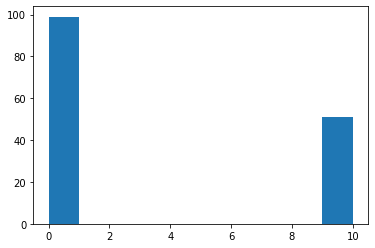

In [90]:
histogram = plt.hist(agent_vars_df.loc[pd.IndexSlice[4207676, :], :].values)

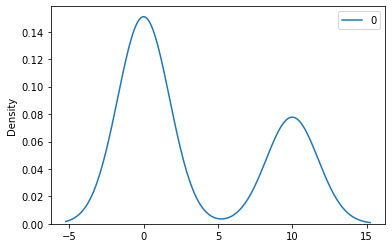

In [91]:
sns.kdeplot(data=agent_wealth);

# Plot Results

## New Plots with 100 Arbitrageurs (no traders and no holders)

In [29]:
plot_time_scale = TimeScale.YEARS

In [59]:
def convert_time_interval_in_seconds_to_indices(
        data_length: int, 
        time_resolution: TimeResolution, 
        time_interval_in_seconds: tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None, 
        plot_time_scale: TimeScale = TimeScale.YEARS, 
        data_interval: int = 1) -> tp.Tuple[int, int]:
    
    begin_time_in_seconds = 0
    end_time_in_seconds = data_length_in_seconds - 1

    if time_interval_in_seconds is not None:
        if time_interval_in_seconds[0] is not None:
            begin_time_in_seconds = time_interval_in_seconds[0]

        if time_interval_in_seconds[1] is not None:
            end_time_in_seconds = time_interval_in_seconds[1]        
    
    begin_index = int(np.floor(begin_time_in_seconds / (data_interval * time_resolution.in_seconds)))
    end_index = int(np.floor(end_time_in_seconds / (data_interval * time_resolution.in_seconds))) + 1
    
    return begin_index, end_index

In [60]:
# def convert_time_interval_in_seconds_to_indices(
#         data_length: int, 
#         time_resolution: TimeResolution, 
#         time_interval_in_seconds: tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None, 
#         plot_time_scale: TimeScale = TimeScale.YEARS, 
#         data_interval: int = 1) -> tp.Tuple[int, int]:
    
#     data_length_in_seconds = data_length * data_interval * time_resolution.in_seconds
    
#     begin_time_in_seconds = 0
#     end_time_in_seconds = data_length_in_seconds - 1

#     if time_interval_in_seconds is not None:
#         if time_interval_in_seconds[0] is not None:
#             begin_time_in_seconds = time_interval_in_seconds[0]

#         if time_interval_in_seconds[1] is not None:
#             end_time_in_seconds = time_interval_in_seconds[1]        
    
#     begin_index = int(np.floor(begin_time_in_seconds / data_length_in_seconds * data_length))
#     end_index = int(np.floor(end_time_in_seconds / data_length_in_seconds * data_length)) + 1
    
#     return begin_index, end_index

In [61]:
def construct_full_time_axis(
    data_length: int, 
    time_resolution: TimeResolution, 
    plot_time_scale: TimeScale = TimeScale.YEARS, 
    data_interval: int = 1):
    return np.linspace(0, data_length * data_interval * time_resolution.in_seconds / plot_time_scale.in_seconds(), data_length)

In [62]:
def construct_time_axis(data_length: int, 
                        time_resolution: TimeResolution, 
                        time_interval_in_seconds: tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None, 
                        plot_time_scale: TimeScale = TimeScale.YEARS, 
                        data_interval: int = 1) -> np.ndarray:
    begin_index, end_index = \
        convert_time_interval_in_seconds_to_indices(
            data_length=data_length, 
            time_resolution=time_resolution, 
            time_interval_in_seconds=time_interval_in_seconds, 
            data_interval=data_interval)
    
    time_axis = np.linspace(0, data_length, data_length)[begin_index:end_index] * time_resolution.in_seconds / plot_time_scale.in_seconds() * data_interval

    return time_axis

In [63]:
time_axis = \
    construct_time_axis(data_length=model_vars_df.shape[0], 
                        time_resolution=time_resolution, 
                        time_interval_in_seconds=(0, 5 * 365.25 * 24 * 60 * 60), 
                        plot_time_scale=plot_time_scale, 
                        data_interval=data_collection_options.data_collection_interval)

In [64]:
def get_indices_and_time_axis_to_plot(
    data_length: int, 
    plot_time_scale: TimeScale, 
    time_resolution: TimeResolution, 
    time_interval_to_plot_in_seconds: tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None, 
    data_interval: int = 1) -> tp.Tuple[int, int, np.ndarray]:
    begin_index, end_index = \
        convert_time_interval_in_seconds_to_indices(
            data_length=model_vars_df.shape[0], 
            time_resolution=time_resolution, 
            time_interval_in_seconds=time_interval_to_plot_in_seconds, 
            data_interval=data_interval)
    
    full_time_axis = \
        construct_full_time_axis(
        data_length=model_vars_df.shape[0], 
        time_resolution=time_resolution, 
        plot_time_scale=plot_time_scale, 
        data_interval=data_collection_options.data_collection_interval)
    
    time_axis_to_plot = full_time_axis[begin_index:end_index]
    
    return begin_index, end_index, time_axis_to_plot


def plot_multiple_variables_over_time(
    model_vars_df: pd.DataFrame, 
    column_name_to_label_map: tp.Dict[str, str], 
    plot_time_scale: TimeScale, 
    time_resolution: TimeResolution, 
    time_interval_to_plot_in_seconds: tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None, 
    figure_size: tp.Tuple[float, float] = DEFAULT_FIGURE_SIZE, 
    data_interval: int = 1):

    begin_index, end_index, time_axis_to_plot = \
        get_indices_and_time_axis_to_plot(
            data_length=model_vars_df.shape[0], 
            plot_time_scale=plot_time_scale, 
            time_resolution=time_resolution, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
            data_interval=data_interval)
    
    plt.figure(figsize=figure_size);
    for column_name, label in column_name_to_label_map.items():
        data_to_plot = model_vars_df.loc[:, column_name].values[begin_index:end_index]
        plt.plot(time_axis_to_plot, data_to_plot, label=label);

    plt.xlabel(f'time in {plot_time_scale.value}');

    
def plot_price_deviations(
    model_vars_df: pd.DataFrame, 
    tickers: tp.Sequence[str], 
    plot_time_scale: TimeScale, 
    time_resolution: TimeResolution, 
    time_interval_to_plot_in_seconds: tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None, 
    figure_size: tp.Tuple[float, float] = DEFAULT_FIGURE_SIZE, 
    data_interval: int = 1):
    
    column_name_to_label_map = \
        {price_deviation_label(ticker): price_deviation_label(ticker)
         for ticker in tickers}
    
    plot_multiple_variables_over_time(
        model_vars_df=model_vars_df, 
        column_name_to_label_map=column_name_to_label_map, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        figure_size=figure_size, 
        data_interval=data_interval)
    
    plt.legend();
    plt.title('Deviation between Spot and Futures Prices');
    

def plot_skews(
    model_vars_df: pd.DataFrame, 
    tickers: tp.Sequence[str], 
    plot_time_scale: TimeScale, 
    time_resolution: TimeResolution, 
    time_interval_to_plot_in_seconds: tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None, 
    figure_size: tp.Tuple[float, float] = DEFAULT_FIGURE_SIZE, 
    data_interval: int = 1):
    
    column_name_to_label_map = \
        {skew_label(ticker): skew_label(ticker)
         for ticker in tickers}
    
    plot_multiple_variables_over_time(
        model_vars_df=model_vars_df, 
        column_name_to_label_map=column_name_to_label_map, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        figure_size=figure_size, 
        data_interval=data_interval)
    
    plt.legend();
    plt.title('Positional Imbalance in Terms of OVL');

    
def plot_single_variable_over_time(
    model_vars_df: pd.DataFrame, 
    column_name: str, 
    plot_time_scale: TimeScale, 
    time_resolution: TimeResolution, 
    time_interval_to_plot_in_seconds: tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None, 
    figure_size: tp.Tuple[float, float] = DEFAULT_FIGURE_SIZE, 
    data_interval: int = 1):
    
    begin_index, end_index, time_axis_to_plot = \
        get_indices_and_time_axis_to_plot(
            data_length=model_vars_df.shape[0], 
            plot_time_scale=plot_time_scale, 
            time_resolution=time_resolution, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
            data_interval=data_interval)
    data_to_plot = model_vars_df.loc[:, column_name].values[begin_index:end_index]

    plt.figure(figsize=figure_size);
    plt.plot(time_axis_to_plot, data_to_plot);
    plt.xlabel(f'time in {plot_time_scale.value}');

    
def plot_supply(
    model_vars_df: pd.DataFrame, 
    plot_time_scale: TimeScale, 
    time_resolution: TimeResolution, 
    time_interval_to_plot_in_seconds: tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None, 
    supply_label: str = SUPPLY_LABEL, 
    figure_size: tp.Tuple[float, float] = DEFAULT_FIGURE_SIZE, 
    data_interval: int = 1):
    plot_single_variable_over_time(
        model_vars_df=model_vars_df, 
        column_name=supply_label, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        figure_size=figure_size, 
        data_interval=data_interval)

    plt.title('OVL Supply');


def plot_treasury(
    model_vars_df: pd.DataFrame, 
    plot_time_scale: TimeScale, 
    time_resolution: TimeResolution, 
    time_interval_to_plot_in_seconds: tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None, 
    treasury_label: str = TREASURY_LABEL, 
    figure_size: tp.Tuple[float, float] = DEFAULT_FIGURE_SIZE, 
    data_interval: int = 1):
    plot_single_variable_over_time(
        model_vars_df=model_vars_df, 
        column_name=treasury_label, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        figure_size=figure_size, 
        data_interval=data_interval)

    plt.title('Treasury');

    
def plot_spot_vs_futures_price(
    model_vars_df: pd.DataFrame, 
    ticker: str, 
    plot_time_scale: TimeScale, 
    time_resolution: TimeResolution, 
    time_interval_to_plot_in_seconds: tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None, 
    figure_size: tp.Tuple[float, float] = DEFAULT_FIGURE_SIZE, 
    data_interval: int = 1):
    column_name_to_label_map = \
        {futures_price_label(ticker): futures_price_label(ticker), 
         spot_price_label(ticker): spot_price_label(ticker)}
    
    plot_multiple_variables_over_time(
        model_vars_df=model_vars_df, 
        column_name_to_label_map=column_name_to_label_map, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        figure_size=figure_size, 
        data_interval=data_interval)

    plt.legend();
    plt.title(f'Spot Price vs Futures Price for {ticker}')

### Set Plot Horizon in Seconds

In [65]:
plot_begin_years = 0.0
# plot_end_years = 5 * 365.25 * 24 * 60 * 60  # 5 years
# plot_end_years = 0.75 * 365.25 * 24 * 60 * 60  # 9 months
plot_end_years = 1 * 365.25 * 24 * 60 * 60  # 1 year
time_interval_to_plot_in_seconds = (plot_begin_years, plot_end_years)

### OVL Supply

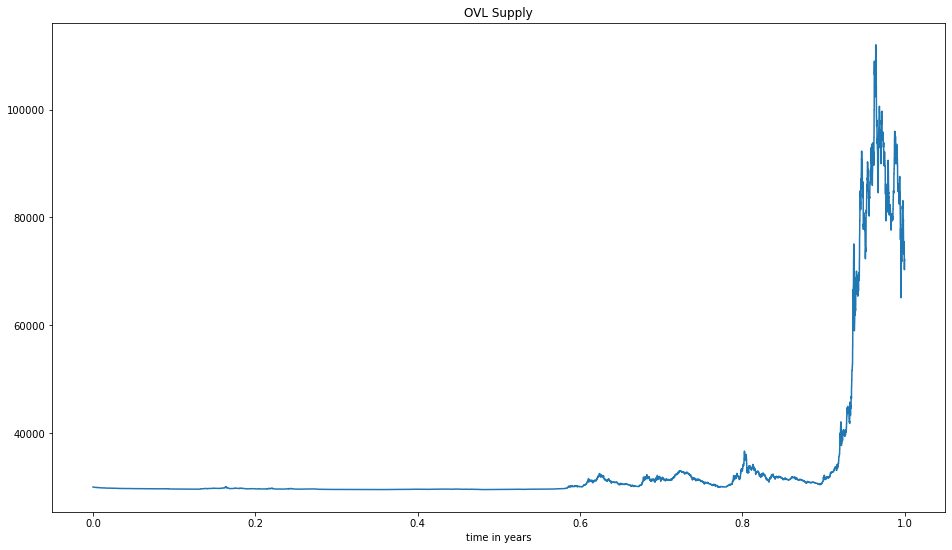

In [66]:
plot_supply(model_vars_df=model_vars_df, 
            plot_time_scale=plot_time_scale, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
            time_resolution=time_resolution, 
            data_interval=4) 

### Treasury

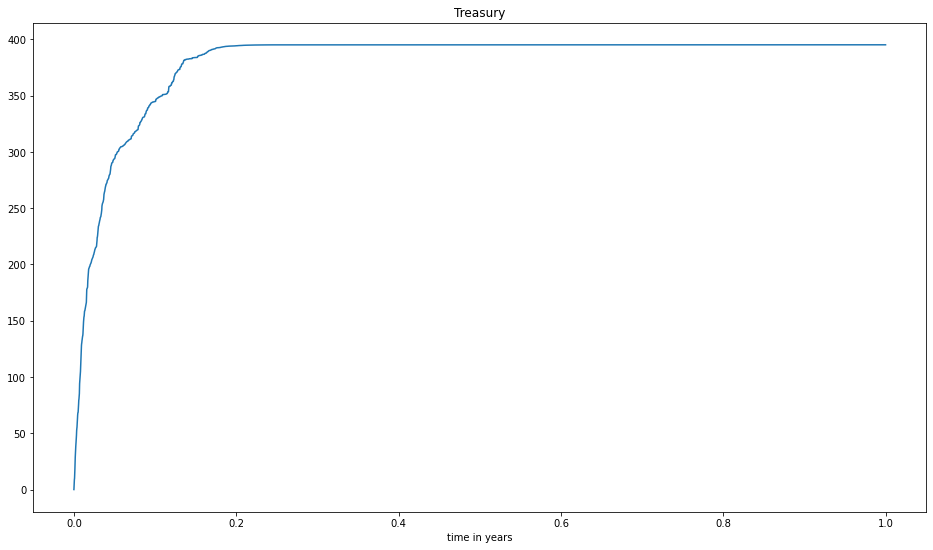

In [67]:
plot_treasury(model_vars_df=model_vars_df, 
              plot_time_scale=plot_time_scale, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
              time_resolution=time_resolution, 
              data_interval=4) 

### Price Deviations

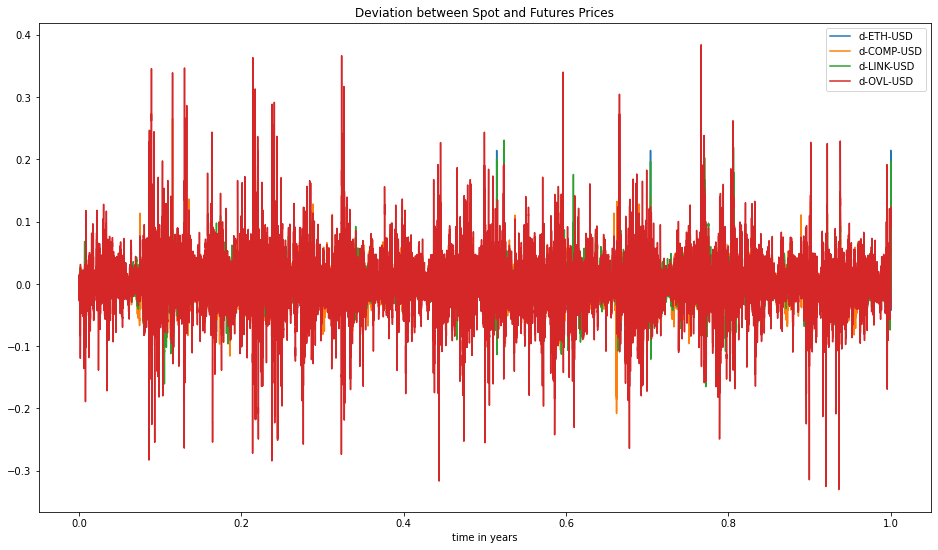

In [68]:
plot_price_deviations(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Skew

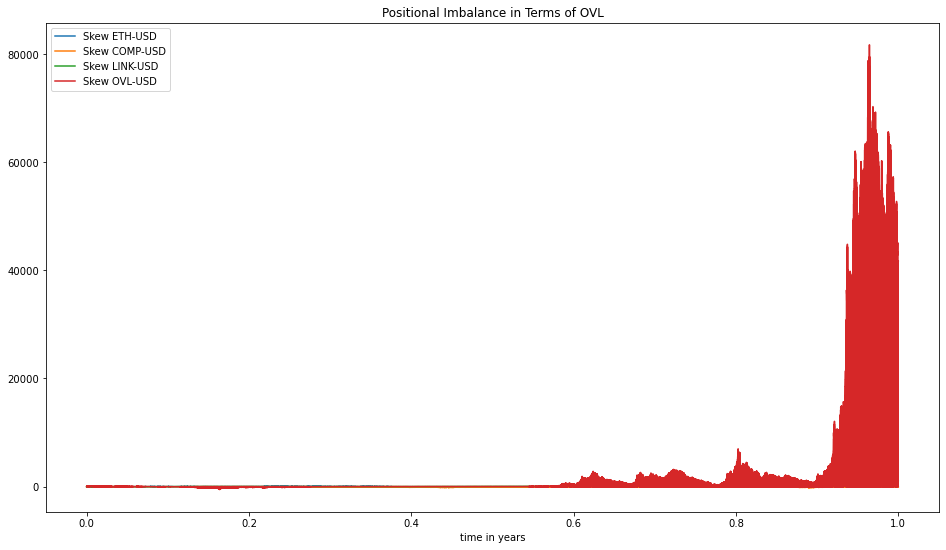

In [69]:
plot_skews(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

#### Correlation between Skew and Futures Price

In [70]:
for i, ticker in enumerate(tickers_with_ovl):
    if i > 0:
        break
    skew = model_vars_df.loc[:, skew_label(ticker)].values
    futures_price = model_vars_df.loc[:, futures_price_label(ticker)].values
    spot_price = model_vars_df.loc[:, spot_price_label(ticker)].values
    print(np.corrcoef(skew, futures_price))
    print(np.corrcoef(skew, spot_price))

[[ 1.         -0.43339917]
 [-0.43339917  1.        ]]
[[ 1.         -0.43268546]
 [-0.43268546  1.        ]]


### Spot vs. Futures Prices

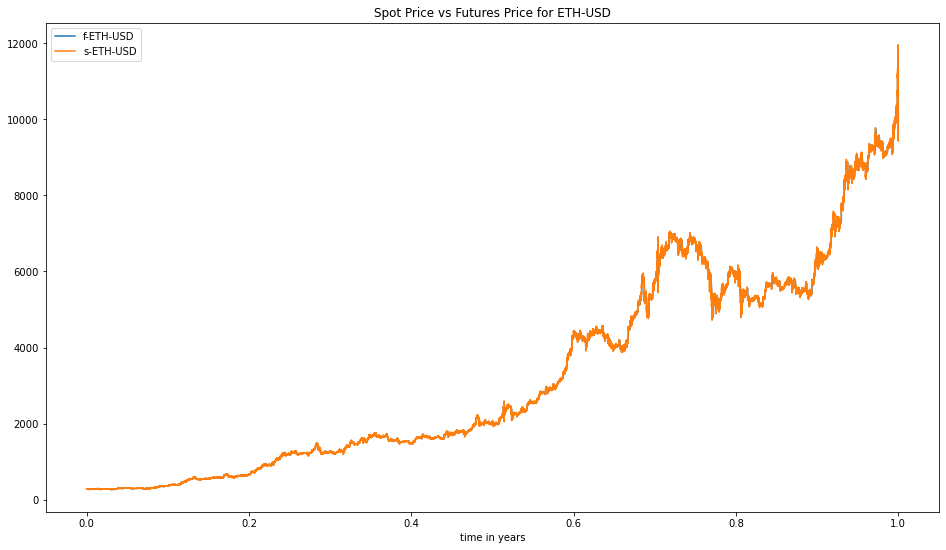

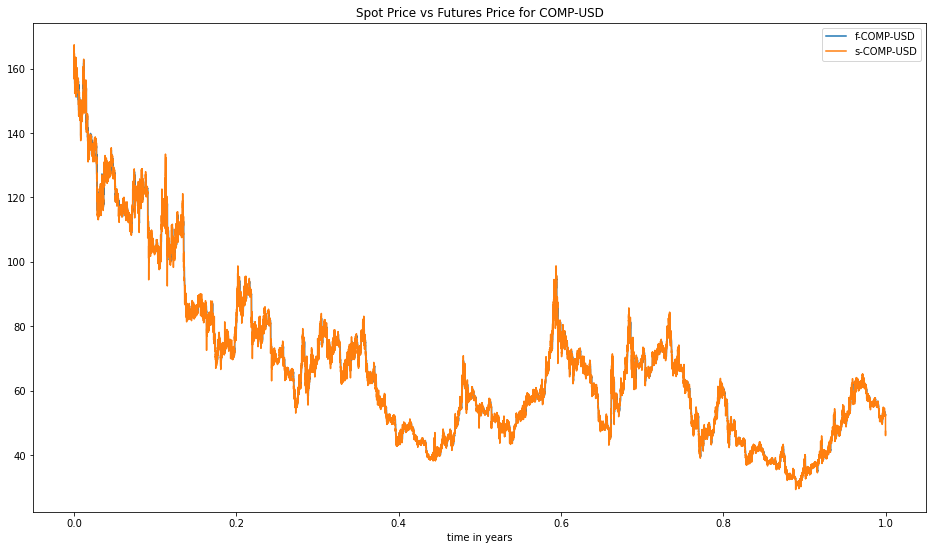

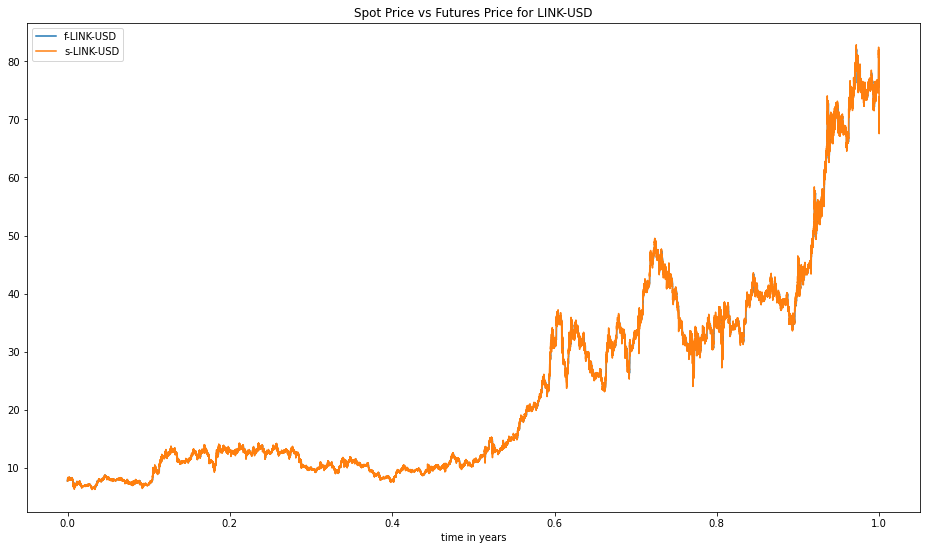

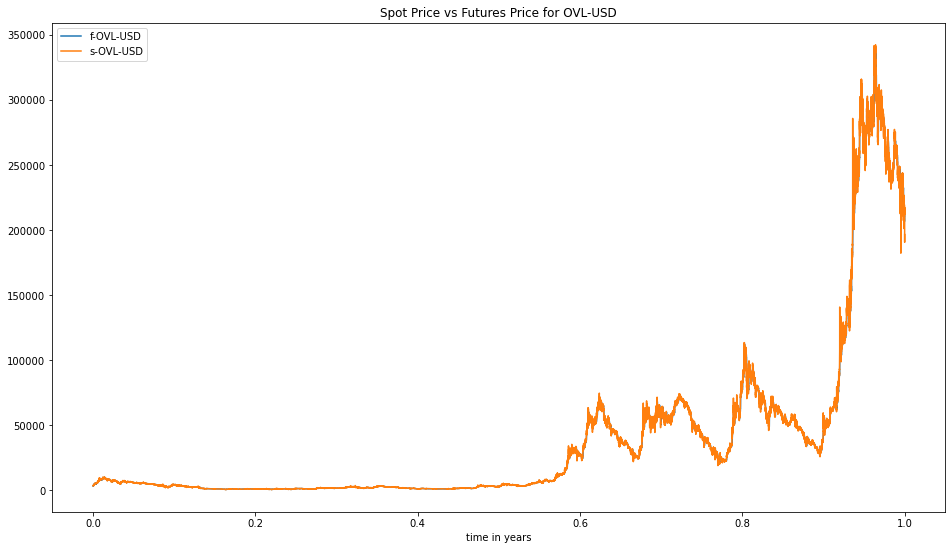

In [71]:
for i, ticker in enumerate(tickers_with_ovl):
    plot_spot_vs_futures_price(
        model_vars_df=model_vars_df, 
        ticker=ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)

In [72]:
plt.close('all')